In [1]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange

# from utils import read_trc, read_mot
# import ocfeats

# gdrive = Path('/Volumes/GoogleDrive-112026393729621442608')
gdrive = Path('/Users/psr/Library/CloudStorage/GoogleDrive-paru@stanford.edu')
datadir = gdrive / 'My Drive/NMBL Lab/OpenCap for NMD biomarkers/data'
dataset = '2023-05_dhd'


In [2]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466"]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72



In [3]:
df_session = pd.read_excel(datadir / dataset / 'session_info.xlsx', )
df_trial = pd.read_excel(datadir / dataset / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / dataset / 'participant_info.xlsx')

feats_path = Path('./feats.pkl')
df_feat = pd.read_pickle(feats_path)

survey_fpath = gdrive / datadir / dataset / 'redcap_data/DHD Data Export_6June2023.csv'
df_survey = pd.read_csv(survey_fpath, usecols=['open_id', 'activ_total'] + [f'activ_{i+1}' for i in range(22)])
df_survey['pid'] = df_survey.open_id.apply(lambda x: x.lower() if isinstance(x, str) else x)
df_survey.drop(columns='open_id', inplace=True)
# df_survey = df_survey[['pid'] + list(df_survey.columns[:-1])]


In [4]:
oc_feats = list(df_feat.columns[1:])
tft_feats = [f for f in df_part.columns if f.startswith('time_')]
tfts_and_brooke = tft_feats + ['brooke']
pro_feats = list(df_survey.columns[1:-1])

df_all = df_feat.merge(df_part, on='pid', how='outer')
df_all = df_all.merge(df_survey, on='pid', how='outer')


In [5]:
tft_feats = [x for x in tft_feats if 'line' not in x]


In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

def three_class_lda_cv(data, feats, label, show=True, saveto=None):
    df_train = data[['pid']+[label]+feats].dropna()

    X = df_train.loc[:,feats].values
    y = df_train.loc[:,label].values

    X -= X.mean(axis=0)
    X /= X.std(axis=0)

    lda = LinearDiscriminantAnalysis(n_components=2)

    df_out = df_train[['pid', 'type']].copy()
    df_out.loc[:,['lda1', 'lda2', 'pred']] = np.nan
    # df_out.set_index('pid', inplace=True)
    df_out

    N_samples = X.shape[0]
    for pid in df_out.pid.unique():
        idx_train = df_out.pid != pid
        idx_test = ~idx_train

        X_train = X[idx_train, :]
        y_train = y[idx_train]
        lda.fit(X_train, y_train)
        df_out.loc[idx_test, ['lda1', 'lda2']] = lda.transform(X[idx_test])
        df_out.loc[idx_test, ['pred']] = lda.predict(X[idx_test,:])

    acc = accuracy_score(y, df_out.pred)

    if show:
        plt.figure(figsize=(5,4))
        sns.scatterplot(df_out, x='lda1', y='lda2', hue='type',
                        palette=[cp[0], cp[3], cp[1]],
                        hue_order=['DM', 'FSHD', 'CTL'],
                        s=15)
        plt.legend(loc='center left',
                   # frameon=False, borderpad=0, borderaxespad=0,
                   bbox_to_anchor=(1, 0.5))
        plt.xlabel('LDA Feature 1')
        plt.ylabel('LDA Feature 2')
        plt.title(f'Accuracy = {acc:0.3f}')
        sns.despine()
        plt.tight_layout()
        if saveto:
            plt.savefig(saveto, dpi=300)
        plt.show()
    
    return df_out, acc


In [7]:
oc_feats

['max_mean_sa',
 'mean_ea_at_max_mean_sa',
 'max_min_sa',
 'max_ea_at_max_min_sa',
 'reachable_workspace',
 'brooke_max_mean_sa',
 'brooke_max_mean_ea',
 'brooke_max_min_sa',
 'brooke_max_ea_at_max_min_sa',
 'curls_max_mean_ea',
 'walk_speed',
 'walk_com_sway',
 'walk_mean_ptp_hip_add',
 'walk_mean_max_ka',
 'run_speed',
 'run_com_sway',
 'run_mean_ptp_hip_add',
 'run_mean_max_ka',
 'jump_max_com_vel',
 'toe_stand_mean_int_aa',
 'toe_stand_int_com_elev',
 'toe_stand_int_com_fwd',
 'toe_stand_int_mean_heel_elev']

Included Data:
 CTL 35
  DM 22
FSHD 23


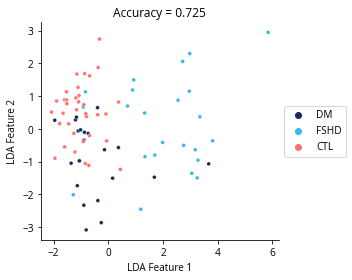

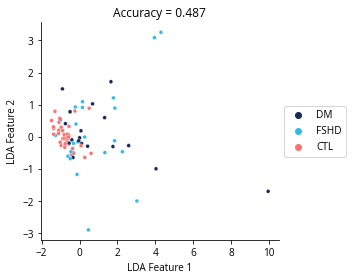

0.725 0.4875 0.2375 0.48717948717948717


In [8]:
feats = oc_feats
feats = ['brooke_max_min_sa',
         'mean_ea_at_max_mean_sa',
         'reachable_workspace',
         'run_speed',
         'jump_max_com_vel',
         'toe_stand_mean_int_aa']
all_feats = feats + tft_feats + ['brooke'] + ['activ_total']

df_include = df_all[['pid', 'type']+all_feats].dropna()

counts = df_include.groupby('type').count()['pid'].reset_index()
print("Included Data:")
print(counts.to_string(index=False, header = False))

df_out_oc, acc_oc = three_class_lda_cv(df_include, feats, 'type',
                                      saveto='./lda_bs_acc_oc.png')
# df_out_oc, acc_oc = three_class_lda_cv(df_include, tft_feats, 'type')
# df_out_oc, acc_oc = three_class_lda_cv(df_include, tft_feats + ['brooke'], 'type')
# df_out_oc, acc_oc = three_class_lda_cv(df_include, tft_feats + feats, 'type')
# df_out_oc, acc_oc = three_class_lda_cv(df_include, tft_feats + feats + ['brooke'], 'type')
df_out_tft, acc_tft = three_class_lda_cv(df_include, tft_feats, 'type',
                                      saveto='./lda_bs_acc_tft.png')

print(acc_oc, acc_tft, acc_oc-acc_tft, (acc_oc - acc_tft) / acc_tft)


In [9]:
rng = np.random.default_rng(0)

N_sims = 1000 
acc_ocs = []
acc_tfts = []
for k in trange(N_sims):

    N_samps = df_include.shape[0]
    df_resamp = df_include.sample(N_samps, replace=True).copy()

    df_out_oc, acc_oc = three_class_lda_cv(df_resamp, feats, 'type', show=False)
    df_out_tft, acc_tft = three_class_lda_cv(df_resamp, tft_feats, 'type', show=False)

    acc_ocs.append(acc_oc)
    acc_tfts.append(acc_tft)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

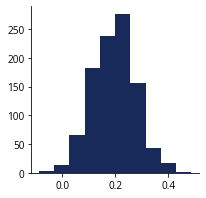

mean accuracy difference 19.5%
95% CI [3.7%, 35.0%]


In [10]:
acc_ocs = np.array(acc_ocs)
acc_tfts = np.array(acc_tfts)
acc_diff = acc_ocs - acc_tfts

plt.figure(figsize=(3,3))
plt.hist(acc_diff)
plt.show()

sorted_acc_diff = np.sort(acc_diff)
ci_lo = np.percentile(sorted_acc_diff, 2.5)
ci_hi = np.percentile(sorted_acc_diff, 97.5)

print(f'mean accuracy difference {acc_diff.mean()*100:0.1f}%')
print(f'95% CI [{ci_lo*100:0.1f}%, {ci_hi*100:0.1f}%]')


In [11]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

def pro_lr_cv(data, feats, label, show=True, saveto=None):
    df_train = data[['pid', 'type']+[label]+feats].dropna()

    X = df_train.loc[:,feats].values
    y = df_train.loc[:,label].values

    reg = linear_model.LinearRegression()

    df_out = df_train[['pid', 'type', label]].copy()
    df_out.loc[:,['lda1', 'lda2', 'pred']] = np.nan

    N_samples = X.shape[0]
    for pid in df_out.pid.unique():
        idx_train = df_out.pid != pid
        idx_test = ~idx_train

        reg.fit(X[idx_train, :], y[idx_train])
        df_out.loc[idx_test, ['pred']] = reg.predict(X[idx_test,:])

    r2 = r2_score(y, df_out.pred)
    mse = mean_squared_error(y, df_out.pred)
    rmse = mean_squared_error(y, df_out.pred, squared=False)

    if show:
        plt.figure(figsize=(5,4))
        sns.scatterplot(df_out, x=label, y='pred', hue='type',
                        palette=[cp[0], cp[3], cp[1]],
                        hue_order=['DM', 'FSHD', 'CTL'],
                        s=15)
        plt.legend(loc='center left',
                   # frameon=False, borderpad=0, borderaxespad=0,
                   bbox_to_anchor=(1, 0.5))
        plt.title(f'R2 = {r2:0.3f}, RMSE = {rmse:0.3f}')
        sns.despine()
        plt.xlabel('Aggregate PRO Score')
        plt.ylabel('Predicted PRO Score')
        plt.tight_layout()
        if saveto:
            plt.savefig(saveto, dpi=300)
        plt.show()
    
    return df_out, r2, mse, rmse


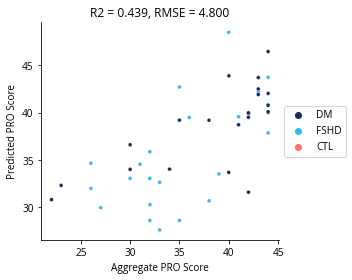

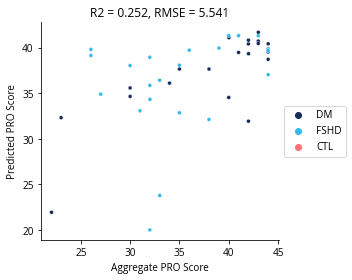

In [12]:
df_include_nmd = df_include[df_include.type != 'CTL']

df_out, r2, mse, rmse = pro_lr_cv(df_include_nmd, feats, 'activ_total',
                                 saveto='pro_reg_cv_oc.png')
df_out, r2, mse, rmse = pro_lr_cv(df_include_nmd, tft_feats, 'activ_total',
                                 saveto='pro_reg_cv_tft.png')


In [13]:
rng = np.random.default_rng(0)

N_sims = 1000 
r2_ocs = []
r2_tfts = []
mse_ocs = []
mse_tfts = []
rmse_ocs = []
rmse_tfts = []
for k in trange(N_sims):

    N_samps = df_include_nmd.shape[0]
    df_resamp = df_include_nmd.sample(N_samps, replace=True).copy()

    df_out_oc, r2_oc, mse_oc, rmse_oc = pro_lr_cv(df_resamp, feats, 'activ_total', show=False)
    df_out_tft, r2_tft, mse_tft, rmse_tft = pro_lr_cv(df_resamp, tft_feats, 'activ_total', show=False)

    r2_ocs.append(r2_oc)
    r2_tfts.append(r2_tft)
    mse_ocs.append(mse_oc)
    mse_tfts.append(mse_tft)
    rmse_ocs.append(rmse_oc)
    rmse_tfts.append(rmse_tft)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

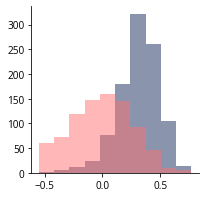

[-0.18809187  1.38865478]


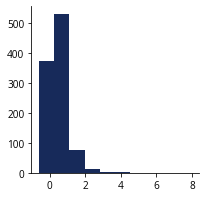

In [14]:
r2_ocs = np.array(r2_ocs)
r2_tfts = np.array(r2_tfts)

plt.figure(figsize=(3,3))
_, bins, _ = plt.hist(r2_ocs, bins=10, alpha=0.5)
plt.hist(r2_tfts, bins=bins, alpha=0.5)
plt.show()

plt.figure(figsize=(3,3))
# plt.hist(r2_ocs, bins=10, alpha=0.5)
plt.hist(r2_ocs - r2_tfts)
print(np.percentile(r2_ocs - r2_tfts, [5, 95]))
plt.show()


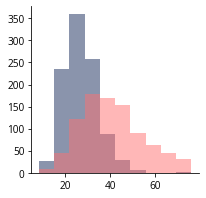

[-0.29032762  0.72344116]


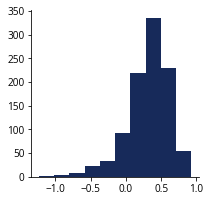

In [15]:
mse_ocs = np.array(mse_ocs)
mse_tfts = np.array(mse_tfts)

plt.figure(figsize=(3,3))
_, bins, _ = plt.hist(mse_ocs, bins=10, alpha=0.5)
plt.hist(mse_tfts, bins=bins, alpha=0.5)
plt.show()

plt.figure(figsize=(3,3))
# plt.hist(r2_ocs, bins=10, alpha=0.5)
mse_diff = (mse_tfts - mse_ocs) / mse_tfts
plt.hist(mse_diff)
print(np.percentile(mse_diff, [5, 95]))
plt.show()

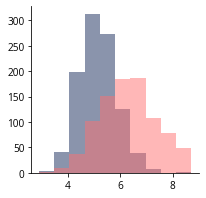

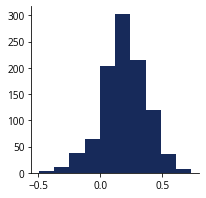

mean RMSE % diff 19.3%
95% CI [-13.6%, 47.4%]


In [16]:
rmse_ocs = np.array(rmse_ocs)
rmse_tfts = np.array(rmse_tfts)

plt.figure(figsize=(3,3))
_, bins, _ = plt.hist(rmse_ocs, bins=10, alpha=0.5)
plt.hist(rmse_tfts, bins=bins, alpha=0.5)
plt.show()

plt.figure(figsize=(3,3))
# plt.hist(r2_ocs, bins=10, alpha=0.5)
rmse_diff = (rmse_tfts - rmse_ocs) / rmse_tfts
plt.hist(rmse_diff)
plt.show()

mean_rmse_diff = np.mean(rmse_diff)
ci_lo, ci_hi = np.percentile(rmse_diff, [5, 95])

print(f'mean RMSE % diff {mean_rmse_diff*100:0.1f}%')
print(f'95% CI [{ci_lo*100:0.1f}%, {ci_hi*100:0.1f}%]')


In [17]:
tft_feats


['time_10mwt', 'time_10mwrt', 'time_tug_cone', 'time_5xsts', 'time_stairs_up']

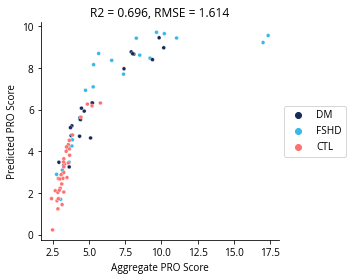

In [18]:
_ = pro_lr_cv(df_include, feats, 'time_10mwrt')
# _ = pro_lr_cv(df_include_nmd, tft_feats, 'activ_total')
